# Import libs

In [193]:
!pip install linearmodels

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels import PanelOLS, RandomEffects, PooledOLS
from statsmodels.stats.diagnostic import het_breuschpagan
import numpy.linalg as la
from scipy import stats
import seaborn as sns
import numpy as np

In [195]:
df = pd.read_excel("data.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      360 non-null    object 
 1   year    360 non-null    int64  
 2   v1      329 non-null    float64
 3   v2      338 non-null    float64
 4   v3      338 non-null    float64
 5   v4      307 non-null    float64
 6   v5      359 non-null    float64
 7   v6      359 non-null    float64
 8   v7      360 non-null    int64  
 9   v8      360 non-null    float64
 10  v9      342 non-null    float64
 11  v10     350 non-null    float64
 12  v11     351 non-null    float64
 13  v12     352 non-null    float64
 14  v13     354 non-null    float64
 15  v14     354 non-null    float64
 16  v15     338 non-null    float64
 17  v16     316 non-null    float64
 18  v17     323 non-null    float64
 19  v18     360 non-null    float64
 20  v19     360 non-null    float64
 21  v20     352 non-null    float64
 22  v2

In [196]:
# Types of variables
for t in df.dtypes.unique():
    print('Type: {}\n{}\n'.format(t, df.dtypes[df.dtypes==t].index.values))

Type: object
['id']

Type: int64
['year' 'v7' 'v23']

Type: float64
['v1' 'v2' 'v3' 'v4' 'v5' 'v6' 'v8' 'v9' 'v10' 'v11' 'v12' 'v13' 'v14'
 'v15' 'v16' 'v17' 'v18' 'v19' 'v20' 'v21' 'v22' 'v24' 'v25' 'v26' 'v27'
 'v28' 'v29' 'v30' 'v31' 'v32' 'v33' 'v34' 'v35' 'v36' 'v37' 'v38']



In [197]:
df_ind = df.set_index(['id', 'year'])

In [198]:
df.head()

,id,year,v1,v2,v3,v4,v5,v6,v7,v8,...,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38
0,Albania,2015,NaN,NaN,NaN,39699.53,242870.0,8.402315,226718,7.843521,...,3030.0,3952.802538,8.194605,80.694759,11.110635,27.267391,44.533615,4.896312,9.6,78.025
1,Albania,2016,NaN,26634.0,306.0,30279.78,266379.0,9.228641,248640,8.614077,...,3285.0,4090.371657,7.769623,80.961061,11.269315,28.977899,45.831964,4.916017,9.4,78.194
2,Albania,2017,NaN,204090.0,1904.0,53273.59,303612.0,10.526845,246720,8.554284,...,3497.0,4249.803734,8.893543,79.608056,11.498401,31.569808,46.624466,5.012636,9.4,78.333
3,Albania,2018,0.000000,303137.0,2935.0,13648.00,361947.0,12.555659,248631,8.624815,...,3713.0,4431.539181,9.605795,79.107646,11.286560,31.571927,45.236191,5.232072,9.5,78.458
4,Algeria,2015,21.901645,5400896.0,65940.0,1635509.00,2269348.0,5.712209,3267592,8.224904,...,7718.0,4177.889542,37.429177,41.010477,21.560346,23.171778,36.523351,6.978489,25.2,76.090


Conclusion:
    - All variables are numeric -> ratio variables
    - All the data are real data (economical, demographically and technical). NaN values shouldn't be handled. It can reduce the quality of the models in this case.

# Select dependent variable and predictors

In [199]:
for i in df:
    if df[i].isna().sum() == 0:
        print(i)

id
year
v7
v8
v18
v19
v22
v23
v24
v30
v31
v32
v33
v34
v35
v36
v37
v38


We have several columns with non NaN data. We need to choose from this variable the dependent variable. <br> Let's choose **v38** variable, because others variable are economic or technical, which can demonstrates closely the same (bad model can be). It's only one social variable.

## Predictors

Let's use correlation approach to choose predictors (one of the good options for panel data). At this situations, we have several years. It means, we should choose variables, which save its correlation particular the same throughout the years.

In [200]:
years = [2015, 2016, 2017, 2018]

for year in years:
    df_year = df[df['year'] == year]
    df_year.set_index('year')
    print(f"Correlations for year {year}")
    print(df_year.corrwith(df_year['v38']).sort_values(ascending=False))
    print()

Correlations for year 2015
v38     1.000000
v6      0.770184
v15     0.761418
v8      0.719560
v30     0.705516
v24     0.584467
v36     0.445047
v9      0.396235
v19     0.325517
v31     0.302663
v34     0.289596
v16     0.226837
v12     0.226335
v33     0.218547
v1      0.200844
v27     0.193158
v14     0.187459
v10     0.180107
v22     0.177122
v11     0.171693
v2      0.159554
v25     0.148372
v3      0.144720
v23     0.144553
v7      0.129000
v13     0.126845
v35     0.120755
v20     0.118358
v29     0.116473
v26     0.111906
v5      0.092434
v21     0.090474
v4      0.079114
v28     0.062256
v17     0.049189
v18    -0.101903
v32    -0.368324
v37    -0.844212
year         NaN
dtype: float64

Correlations for year 2016
v38     1.000000
v6      0.782911
v15     0.769737
v8      0.716108
v30     0.710332
v24     0.479959
v36     0.475931
v19     0.363266
v9      0.360769
v31     0.341519
v34     0.284255
v16     0.230993
v12     0.201167
v14     0.197572
v33     0.195373
v1      0.19

Now let's calculate the difference throughout years.

In [201]:
for i in range(3):
    df_year1 = df[df['year'] == years[i]]
    df_year2 = df[df['year'] == years[i + 1]]
    df_diff = pd.DataFrame()
    for v in df_year1.columns:
        if v == 'year' or v == 'id':
            continue
        l2 = df_year2[v].tolist()
        l1 = df_year1[v].tolist()
        diff = []
        for j in range(len(l1)):
            diff.append(l2[j] - l1[j])
        df_diff[v] = diff
    print(f"Correlations for years {years[i+1]}-{years[i]}")
    print(df_diff.corrwith(df_diff['v38']).sort_values(ascending=False))
    print()

Correlations for years 2016-2015
v38    1.000000
v13    0.185105
v35    0.181689
v34    0.173739
v36    0.105746
v32    0.077646
v22    0.065608
v33    0.059941
v4     0.043645
v11    0.041275
v28    0.015145
v8     0.012166
v10    0.012044
v17    0.011505
v7     0.007601
v21    0.005804
v5    -0.009478
v14   -0.012750
v1    -0.018279
v12   -0.025738
v18   -0.029026
v26   -0.038454
v15   -0.057669
v9    -0.083881
v31   -0.090434
v6    -0.101562
v3    -0.137442
v2    -0.145335
v19   -0.166283
v29   -0.169191
v20   -0.169396
v23   -0.191431
v30   -0.208903
v16   -0.239106
v27   -0.245817
v25   -0.249330
v24   -0.251992
v37   -0.360396
dtype: float64

Correlations for years 2017-2016
v38    1.000000
v31    0.274486
v15    0.132628
v22    0.114124
v3     0.104185
v10    0.098294
v2     0.091578
v19    0.075335
v14    0.061247
v18    0.056443
v28    0.045600
v5     0.042149
v4     0.025387
v34    0.023271
v21    0.015360
v7     0.014088
v36    0.011032
v30    0.003093
v8    -0.011468
v1    

The predictors are (from difference table):
- v35
- v33
- v1
- v12
The predictors are (from correlation by years: highest correlation throughout the years):
- v6
- v30
- v36
The final predictors list:
- v1
- v6
- v12
- v30
- v33
- v35
- v36

# Hypothesis

In [202]:
predictors = ['v1', 'v6', 'v12', 'v30', 'v33', 'v35', 'v36']
for ind, val in enumerate(predictors):
    print(ind + 1, '. ', 'There is a relationship between dependent variable (v38) and ', val, ' variable.')

1 .  There is a relationship between dependent variable (v38) and  v1  variable.
2 .  There is a relationship between dependent variable (v38) and  v6  variable.
3 .  There is a relationship between dependent variable (v38) and  v12  variable.
4 .  There is a relationship between dependent variable (v38) and  v30  variable.
5 .  There is a relationship between dependent variable (v38) and  v33  variable.
6 .  There is a relationship between dependent variable (v38) and  v35  variable.
7 .  There is a relationship between dependent variable (v38) and  v36  variable.


# Descriptive analysis

In [203]:
# Variable v38
df['v38'].describe()

count    360.000000
mean      76.016128
std        5.328247
min       57.206000
25%       73.232500
50%       76.304000
75%       80.964634
max       84.210976
Name: v38, dtype: float64

<AxesSubplot:>

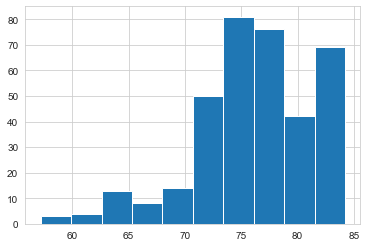

In [204]:
df['v38'].hist()

The distribution of the dependent variable aren't normal. The majority of the values are located at the right part of the bar chart. It means, most of the countries have high life expectancy

Life expecanty in 2015
count    90.000000
mean     75.685932
std       5.456769
min      57.206000
25%      73.040000
50%      75.998000
75%      80.687195
max      83.793902
Name: v38, dtype: float64


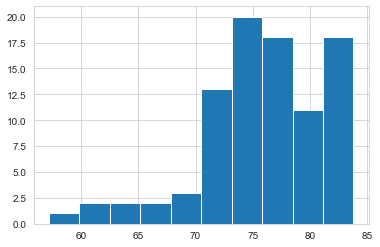

Life expecanty in 2016
count    90.000000
mean     75.946791
std       5.393680
min      58.309000
25%      73.273000
50%      76.215500
75%      80.956098
max      83.984878
Name: v38, dtype: float64


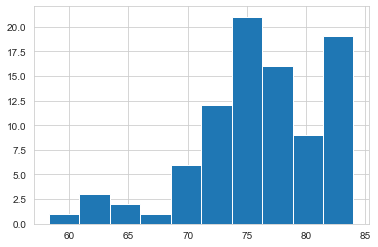

Life expecanty in 2017
count    90.000000
mean     76.130276
std       5.293265
min      59.309000
25%      73.482750
50%      76.421000
75%      81.075000
max      84.099756
Name: v38, dtype: float64


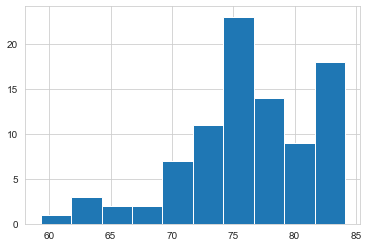

Life expecanty in 2018
count    90.000000
mean     76.301511
std       5.236450
min      60.163000
25%      73.673000
50%      76.606500
75%      80.938415
max      84.210976
Name: v38, dtype: float64


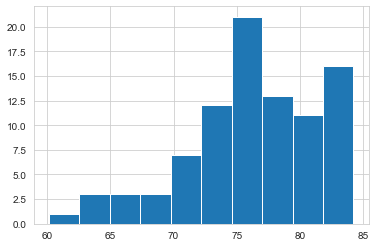

In [205]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"Life expecanty in {year}")
    print(df_year['v38'].describe())
    df_year['v38'].hist()
    plt.show()

We can say that the trend of the variable is flexible right now. Firstly, the trend was downstream. But in the end of the period we can say that the trend is increasing. However, 4 years is really lack of data to identify the global trend of this data.

<AxesSubplot:xlabel='year'>

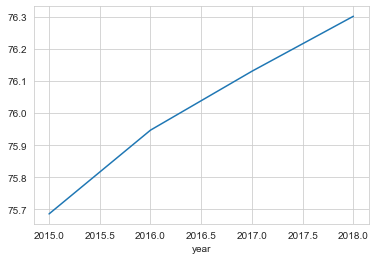

In [206]:
df.groupby('year')['v38'].mean().plot()

Here we can see the increase in this variable.

In [207]:
# Variable v1
df['v1'].describe()

count      329.000000
mean      1818.166288
std       5328.783124
min          0.000000
25%          7.843989
50%        168.773000
75%       1226.441990
max      42985.299596
Name: v1, dtype: float64

<AxesSubplot:>

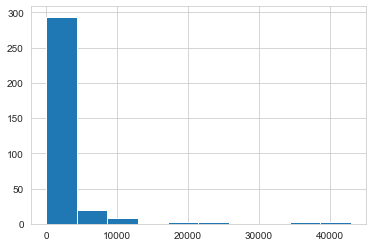

In [208]:
df['v1'].hist()

The distribution isn't normal. Most of the dat are less than the average.

Air transport, freight in 2015
count       82.000000
mean      1684.715891
std       4969.506762
min          0.000087
25%          8.204032
50%        168.939000
75%       1125.465818
max      37866.224512
Name: v1, dtype: float64


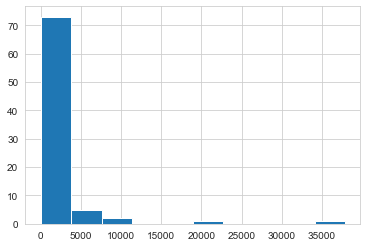

Air transport, freight in 2016
count       81.000000
mean      1765.223798
std       5154.534675
min          0.003000
25%          8.022034
50%        157.239000
75%       1142.854709
max      38657.919041
Name: v1, dtype: float64


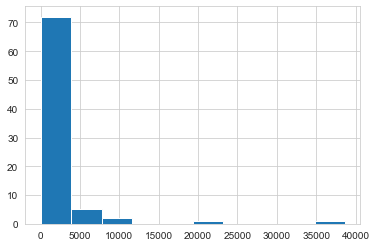

Air transport, freight in 2017
count       80.000000
mean      1939.032928
std       5602.544073
min          0.021650
25%         11.731028
50%        205.287785
75%       1289.164780
max      41591.551767
Name: v1, dtype: float64


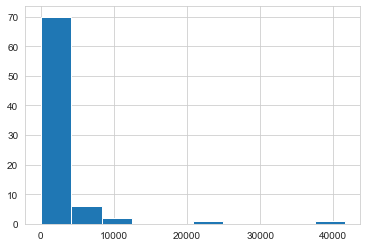

Air transport, freight in 2018
count       86.000000
mean      1882.840044
std       5641.280204
min          0.000000
25%          4.867058
50%        166.178904
75%       1202.809856
max      42985.299596
Name: v1, dtype: float64


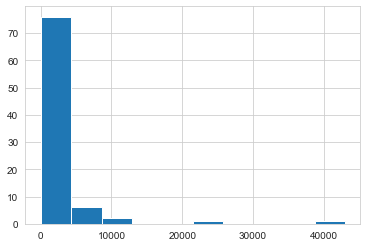

In [209]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"Air transport, freight in {year}")
    print(df_year['v1'].describe())
    df_year['v1'].hist()
    plt.show()

There isn't any significant changes in this variable over the considered period.

<AxesSubplot:xlabel='year'>

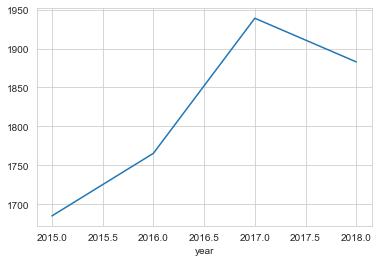

In [210]:
df.groupby('year')['v1'].mean().plot()

2015 - 2017 = increasing trend
2017 - 2018 = decreasing trend

In [211]:
# Variable v6
df['v6'].describe()

count    359.000000
mean      18.890255
std       13.305419
min        0.066192
25%        7.268780
50%       16.667271
75%       30.284036
max       46.319901
Name: v6, dtype: float64

<AxesSubplot:>

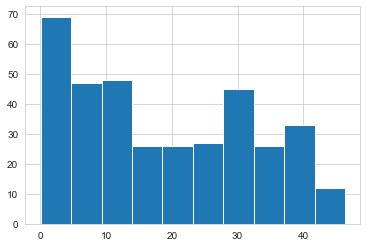

In [212]:
df['v6'].hist()

The distribution isn't normal. Again most of the variable are less than average.

Fixed broadband subscriptions 2015
count    90.000000
mean     17.640446
std      12.947687
min       0.072213
25%       5.729204
50%      15.734519
75%      28.503171
max      44.602427
Name: v6, dtype: float64


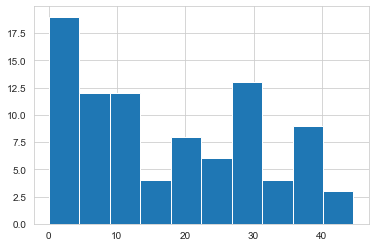

Fixed broadband subscriptions 2016
count    90.000000
mean     18.462317
std      13.222630
min       0.066192
25%       6.906075
50%      16.482966
75%      30.118091
max      45.059110
Name: v6, dtype: float64


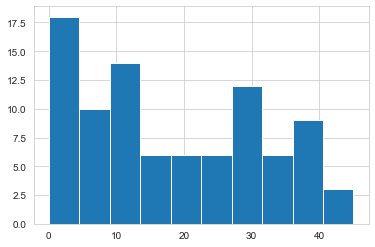

Fixed broadband subscriptions 2017
count    90.000000
mean     19.266180
std      13.506428
min       0.074850
25%       7.547700
50%      17.214980
75%      30.866780
max      46.319901
Name: v6, dtype: float64


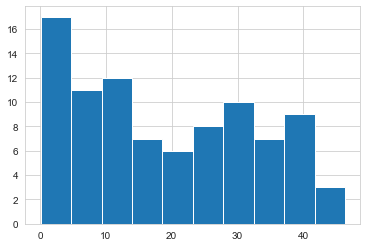

Fixed broadband subscriptions 2018
count    89.000000
mean     20.206703
std      13.625570
min       0.075002
25%       8.098378
50%      19.005035
75%      31.723403
max      45.555421
Name: v6, dtype: float64


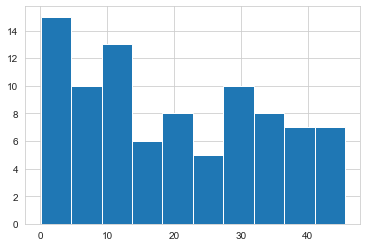

In [213]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"Fixed broadband subscriptions {year}")
    print(df_year['v6'].describe())
    df_year['v6'].hist()
    plt.show()

Over the period, more and more countries has fixed broadcast subscription

<AxesSubplot:xlabel='year'>

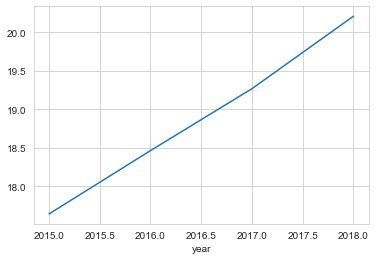

In [214]:
df.groupby('year')['v6'].mean().plot()

There is increasing trend over the period

In [215]:
# Variable v12
df['v12'].describe()

count    352.000000
mean       7.662915
std        5.239612
min        1.112616
25%        4.389048
50%        5.868136
75%        9.007635
max       28.097804
Name: v12, dtype: float64

<AxesSubplot:>

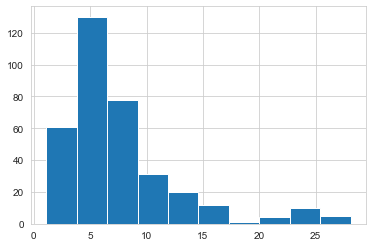

In [216]:
df['v12'].hist()

The distribution isn't normal. Again most of the variable are less than average.

ICT goods imports 2015
count    89.000000
mean      7.800464
std       5.327777
min       2.218812
25%       4.217466
50%       5.764948
75%       9.332875
max      27.474704
Name: v12, dtype: float64


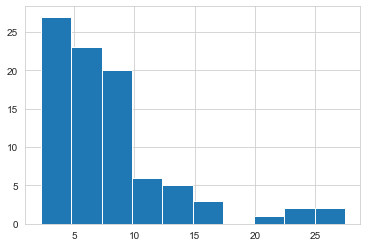

ICT goods imports 2016
count    88.000000
mean      7.816014
std       5.266334
min       2.244557
25%       4.755934
50%       6.218752
75%       9.228722
max      28.097804
Name: v12, dtype: float64


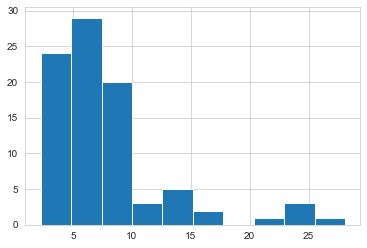

ICT goods imports 2017
count    89.000000
mean      7.516582
std       5.241103
min       1.172655
25%       4.128315
50%       5.698460
75%       8.862665
max      27.880224
Name: v12, dtype: float64


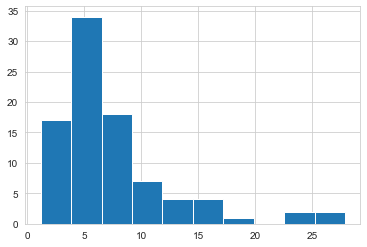

ICT goods imports 2018
count    86.000000
mean      7.515346
std       5.202487
min       1.112616
25%       4.379169
50%       5.938975
75%       8.508615
max      26.610577
Name: v12, dtype: float64


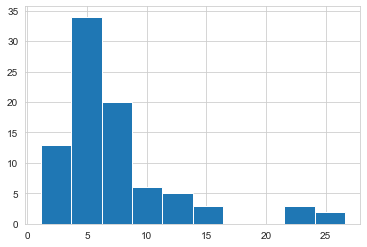

In [217]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"ICT goods imports {year}")
    print(df_year['v12'].describe())
    df_year['v12'].hist()
    plt.show()

For most of the countries ICT goods imports has increasing trend.

<AxesSubplot:xlabel='year'>

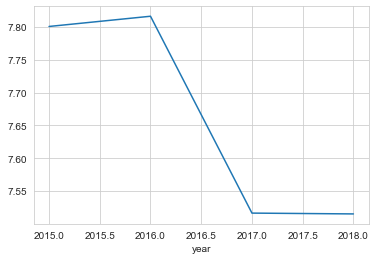

In [218]:
df.groupby('year')['v12'].mean().plot()

Mean trend is downstream over the period

In [219]:
# Variable v30
df['v30'].describe()

count      360.000000
mean     17959.664527
std      19551.338613
min        467.235432
25%       4084.777009
50%       9679.546200
75%      26132.789285
max      87980.670685
Name: v30, dtype: float64

<AxesSubplot:>

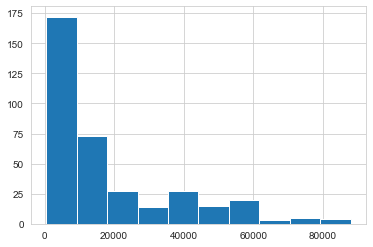

In [220]:
df['v30'].hist()

The same as previous variable

GDP per capita 2015
count       90.000000
mean     17434.895996
std      19128.161943
min        467.235432
25%       3963.261132
50%       9286.730464
75%      24543.286932
max      84776.142166
Name: v30, dtype: float64


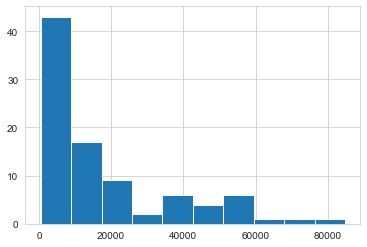

GDP per capita 2016
count       90.000000
mean     17714.037153
std      19375.918757
min        473.005165
25%       4048.211776
50%       9527.122951
75%      25216.932217
max      85570.396058
Name: v30, dtype: float64


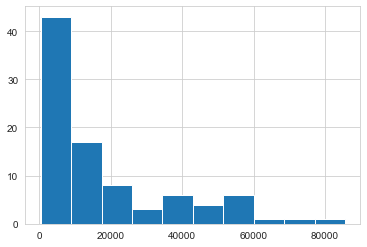

GDP per capita 2017
count       90.000000
mean     18149.587133
std      19790.221062
min        478.610657
25%       4094.881238
50%       9904.585190
75%      26507.632107
max      86119.145373
Name: v30, dtype: float64


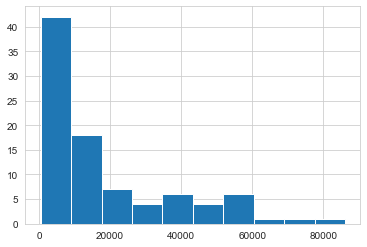

GDP per capita 2018
count       90.000000
mean     18540.137827
std      20204.504603
min        480.888893
25%       4157.980692
50%      10140.812711
75%      27143.785633
max      87980.670685
Name: v30, dtype: float64


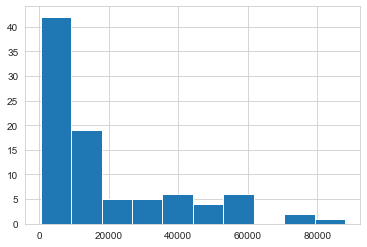

In [221]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"GDP per capita {year}")
    print(df_year['v30'].describe())
    df_year['v30'].hist()
    plt.show()

Increasing trend for some countries over the period

<AxesSubplot:xlabel='year'>

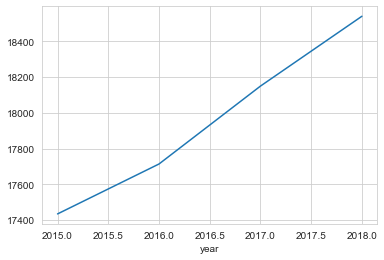

In [222]:
df.groupby('year')['v30'].mean().plot()

There is increasing trend of mean value.

In [223]:
# Variable v33
df['v33'].describe()

count    360.000000
mean      16.417940
std        4.616302
min        4.926273
25%       13.196605
50%       16.367364
75%       19.375953
max       27.228583
Name: v33, dtype: float64

<AxesSubplot:>

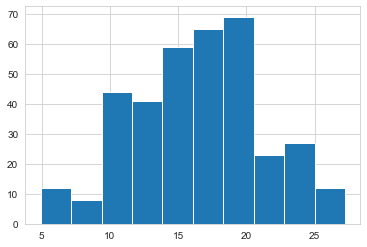

In [224]:
df['v33'].hist()

The distribution isn't normal, but most of the variable are close to the average variable.

General government final consumption expenditure 2015
count    90.000000
mean     16.563308
std       4.688964
min       5.397980
25%      13.237919
50%      17.024148
75%      19.458727
max      27.228583
Name: v33, dtype: float64


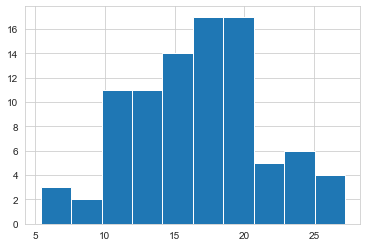

General government final consumption expenditure 2016
count    90.000000
mean     16.623462
std       4.677481
min       5.209980
25%      13.794848
50%      16.536217
75%      19.565566
max      26.987349
Name: v33, dtype: float64


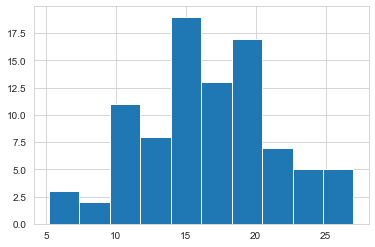

General government final consumption expenditure 2017
count    90.000000
mean     16.310256
std       4.581287
min       5.123498
25%      13.254901
50%      16.298547
75%      19.186939
max      26.022412
Name: v33, dtype: float64


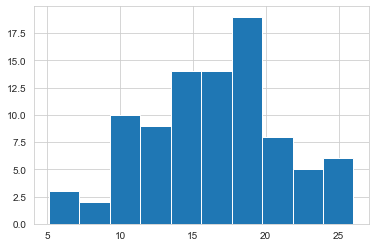

General government final consumption expenditure 2018
count    90.000000
mean     16.174733
std       4.579332
min       4.926273
25%      12.801188
50%      16.331279
75%      19.361673
max      26.059388
Name: v33, dtype: float64


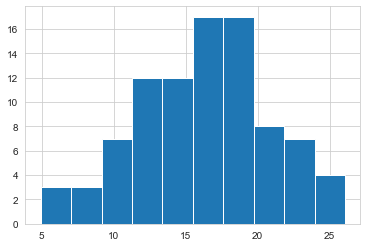

In [225]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"General government final consumption expenditure {year}")
    print(df_year['v33'].describe())
    df_year['v33'].hist()
    plt.show()

Variable demonstrates decreasing trend (some countries decrease governmental final consumption expenditure).

<AxesSubplot:xlabel='year'>

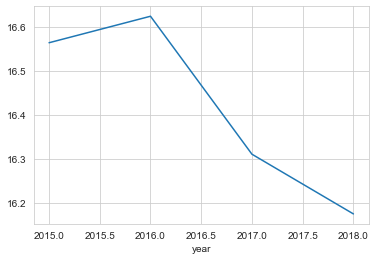

In [226]:
df.groupby('year')['v33'].mean().plot()

The mean value has decreasing trend.

In [227]:
# Variable v35
df['v35'].describe()

count    360.000000
mean      45.566729
std       24.469239
min        0.683885
25%       28.448951
50%       42.082358
75%       57.216309
max      151.086790
Name: v35, dtype: float64

<AxesSubplot:>

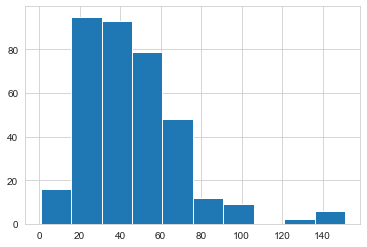

In [228]:
df['v35'].hist()

The distribution is close to normal. The trend shows us that the most of the countries have smaller imports of goods than other countries have.

Imports of goods and services 2015
count     90.000000
mean      45.179270
std       24.915903
min        0.770629
25%       28.443545
50%       42.082358
75%       57.786851
max      151.086790
Name: v35, dtype: float64


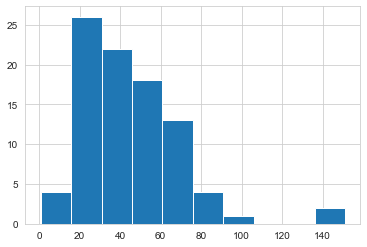

Imports of goods and services 2016
count     90.000000
mean      44.453343
std       24.498965
min        0.742996
25%       27.683736
50%       41.196121
75%       55.851558
max      139.160195
Name: v35, dtype: float64


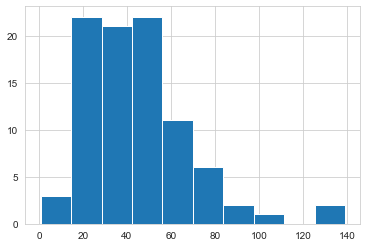

Imports of goods and services 2017
count     90.000000
mean      45.565645
std       24.438553
min        0.798023
25%       27.648391
50%       41.784663
75%       56.983699
max      144.650107
Name: v35, dtype: float64


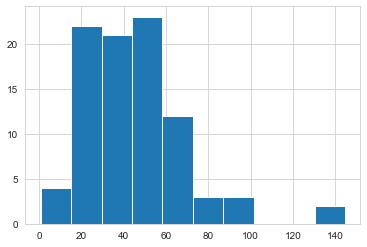

Imports of goods and services 2018
count     90.000000
mean      47.068657
std       24.356234
min        0.683885
25%       29.214606
50%       43.381400
75%       58.950174
max      148.280943
Name: v35, dtype: float64


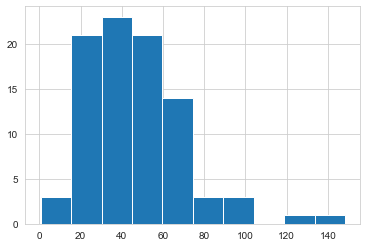

In [229]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"Imports of goods and services {year}")
    print(df_year['v35'].describe())
    df_year['v35'].hist()
    plt.show()

Bar charts shows us the trend that more and more countries become spend more on the imports of goods and services.

<AxesSubplot:xlabel='year'>

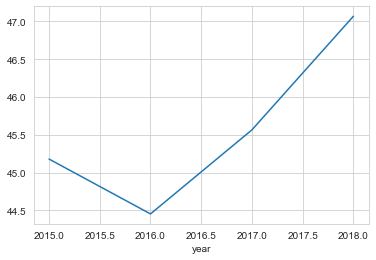

In [230]:
df.groupby('year')['v35'].mean().plot()

The mean value firstly decrease then increase over the period.

In [231]:
# Variable v36
df['v36'].describe()

count    360.000000
mean       7.055710
std        2.491219
min        2.431802
25%        5.163637
50%        6.884151
75%        8.892331
max       16.844324
Name: v36, dtype: float64

<AxesSubplot:>

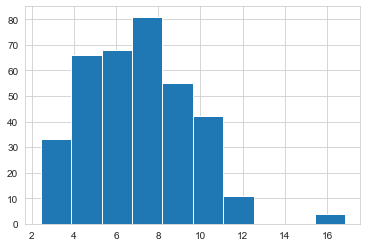

In [232]:
df['v36'].hist()

The distribution is close to normal. Most of the values are close to the mean value.

Current health expenditure 2015
count    90.000000
mean      7.093815
std       2.488884
min       2.639473
25%       5.007076
50%       6.918993
75%       8.887419
max      16.524073
Name: v36, dtype: float64


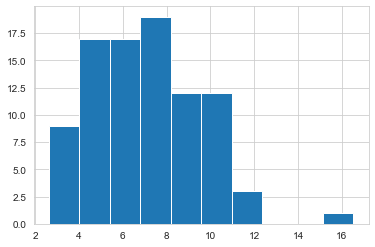

Current health expenditure 2016
count    90.000000
mean      7.082993
std       2.479129
min       2.472912
25%       5.244133
50%       7.050951
75%       8.913129
max      16.844324
Name: v36, dtype: float64


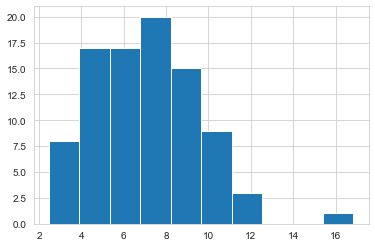

Current health expenditure 2017
count    90.000000
mean      7.035994
std       2.517760
min       2.431802
25%       5.171793
50%       6.878704
75%       8.852641
max      16.805836
Name: v36, dtype: float64


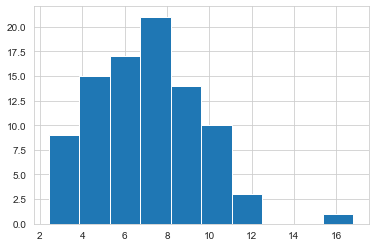

Current health expenditure 2018
count    90.000000
mean      7.010038
std       2.519805
min       2.508030
25%       5.206201
50%       6.802648
75%       8.846424
max      16.687105
Name: v36, dtype: float64


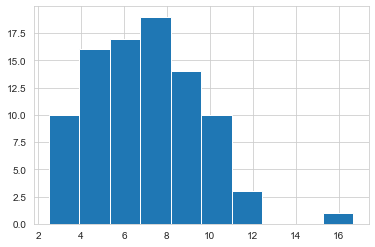

In [233]:
for year in years:
    df_year = df[df['year'] == year]
    print(f"Current health expenditure {year}")
    print(df_year['v36'].describe())
    df_year['v36'].hist()
    plt.show()

There is decreasing trend of spending on the healthcare.

<AxesSubplot:xlabel='year'>

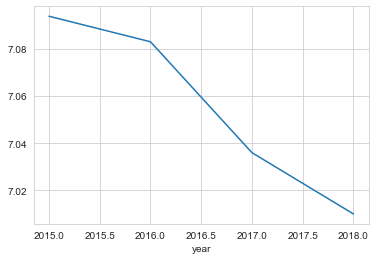

In [234]:
df.groupby('year')['v36'].mean().plot()

The mean value demonstrates decreasing trend of the variable.

# Models

In [235]:
# Pooled model
all = ['v1', 'v6', 'v12', 'v30', 'v33', 'v35', 'v36', 'v38']
pred = ['v1', 'v6', 'v12', 'v30', 'v33', 'v35', 'v36']
df_cleared_all = df_ind[all].dropna()
df_pred = df_cleared_all[pred]

_pred = sm.add_constant(df_pred)
mod = PooledOLS(df_cleared_all['v38'], _pred)
pooled_res = mod.fit()
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                    v38   R-squared:                        0.6838
Estimator:                  PooledOLS   R-squared (Between):              0.6707
No. Observations:                 320   R-squared (Within):              -0.5671
Date:                Fri, May 20 2022   R-squared (Overall):              0.6838
Time:                        16:44:41   Log-likelihood                   -814.02
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      96.384
Entities:                          90   P-value                           0.0000
Avg Obs:                       3.5556   Distribution:                   F(7,312)
Min Obs:                       0.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             96.384
                            

/Users/zhdanov.vdm/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [236]:
# Fixed effect model
mod = PanelOLS(df_cleared_all['v38'], _pred, entity_effects=True)
fe_res = mod.fit()
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    v38   R-squared:                        0.3540
Estimator:                   PanelOLS   R-squared (Between):              0.4109
No. Observations:                 320   R-squared (Within):               0.3540
Date:                Fri, May 20 2022   R-squared (Overall):              0.4158
Time:                        16:44:41   Log-likelihood                    18.645
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      17.774
Entities:                          90   P-value                           0.0000
Avg Obs:                       3.5556   Distribution:                   F(7,227)
Min Obs:                       0.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             17.774
                            

In [237]:
# Random effect model
mod = RandomEffects(df_cleared_all['v38'], _pred)
re_res = mod.fit()
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                    v38   R-squared:                        0.7456
Estimator:              RandomEffects   R-squared (Between):              0.5482
No. Observations:                 320   R-squared (Within):               0.3232
Date:                Fri, May 20 2022   R-squared (Overall):              0.5538
Time:                        16:44:41   Log-likelihood                   -48.466
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      130.64
Entities:                          90   P-value                           0.0000
Avg Obs:                       3.5556   Distribution:                   F(7,312)
Min Obs:                       0.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             31.494
                            

# Choose of the model

## Random effect and Pooled model

H0: there are no individual effects

p-value: >0.05 of accept

In [238]:
residuals_pooled_OLS = pooled_res.resids
pooled_OLS_dataset = pd.concat([df_cleared_all, residuals_pooled_OLS], axis=1)
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], _pred)
print('P-value:', breusch_pagan_test_results[3])

P-value: 1.1258193527197328e-29


p-value < 0.05 => H0 is rejected.
It means, we should choose a model with effects (fixed or random)

## Random effect and fixed effect

H0: individual effects are not correlated (they are random)

p-value: >0.05 of accept

In [239]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B))
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fe_res, re_res)
print('p-value: ' + str(hausman_results[2]))

p-value: 0.001628894304004751


p-value < 0.05 => H0 is rejected.
We should choose the fixed-effects model (FINAL CHOICE)

# Description of the final model

- p-value = 0 -> the model is statistically significant
- R-squared = 0.354 => the model explains 35.4% of the variance
- R-squared (within) = 0.354 => only 35.4% of variations in the dependent variable within units of analysis is captured by the model.
- R-squared (between) = 0.41 => only 41% of variations in the dependent variable between units of analysis is captured by the model.

In [240]:
l = []
for (param, index) in zip(fe_res.params[1:], fe_res.params.index[1:]):
    l.append('{:.7f}*{}'.format(param, index))

print('Y = {:7f} + {}'.format(fe_res.params[0], ' + '.join(l)))

Y = 75.947100 + 0.0000338*v1 + 0.0634062*v6 + -0.0253454*v12 + 0.0000774*v30 + -0.1413677*v33 + 0.0072655*v35 + -0.0706060*v36


In [241]:
f'Statistically significant model parameters: {fe_res.pvalues[fe_res.pvalues < 0.05].index.values}'

"Statistically significant model parameters: ['const' 'v6' 'v30' 'v33']"

In [242]:
f'Statistically nonsignificant model parameters: {fe_res.pvalues[fe_res.pvalues > 0.05].index.values}'

"Statistically nonsignificant model parameters: ['v1' 'v12' 'v35' 'v36']"

# Relationship between predictors

There are 3 statistically-significant predictors:
- Fixed broadband subscriptions
- GDP per capita
- General government final consumption expenditure

Each relationship:
- There is a relationship between ew SMEs created by entrepreneurs under 30 years old and Number of individuals under the age of 30 who have completed training in educational programs aimed at acquiring business skills and creating SMEs. Each increase by one leads to increase in 0.06 years in life expectancy.
- There is a relationship between life expactancy over time and the GDP per capita. Each increase in 1$ in GDP per capita leads to increase in 0,000007 year in life expectancy.
- There is a relationship between life expactancy over time and the general government final consumption expenditure. Each increase in one unit in general government final consumption expenditure leads to 0,14 years decrease in life expectancy.

Others are not statistically significant.

# Final conclusions

The accepted hypothesis:
- There is a relationship between life expactancy over time and the number of fixed broadband subscriptions refers to fixed subscriptions to high-speed access to the public Internet per 100 people.
- There is a relationship between life expactancy over time and GDP per capita.
- There is a relationship between life expactancy over time and the share of general government final consumption expenditure in GDP.

The rejected hypothesis:
- There is a relationship between life expactancy over time and the volume of freight, express, and diplomatic bags carried on each flight stage.
- There is a relationship between life expactancy over time and the share of information and communication technology goods imports of total import.
- There is a relationship between life expactancy over time and the share of imports of goods and services of GDP.
- There is a relationship between life expactancy over time and the level of current health expenditure in percents of GDP.

In the result of the analysis:
- We have managed to extract several indicators which have influence on the life expectancy: Fixed broadband subscriptions, GPD per capita and General government final consumption expenditure.
- The built model is statistically significant, however it explains less than 50% variance, which is not good.
- There are individual fixed effects which influence the life expectancy over time in different. This effects may not be chosen as the predictors or may not included in the datasets.